<a href="https://colab.research.google.com/github/rts1988/Duolingo_spaced_repetition/blob/main/Duolingo_splittingdata_unseen_students.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is for splitting data into train and test for the unseen students question.

We will try to answer the following questions in order.

1. Can we train a model to predict whether a student would have forgotten a certain word when they encounter is after some time? 
2. Based on their performance on one word for a known student, can we improve our prediction on other words? 
3. Can we extract word-based features that can predict the ease and difficulty of remembering them?
4. Can we extract student and session based features that can predict if a word is forgotten?
4. Can we predict how easy or difficult a word is to remember for a new language based on our learnings?

Splitting the dataset:

1. first split - keep two languages aside for cold-start testing - done
2. second split - keep some unseen students aside for testing on seen words. include some low and high trace lengths (10%?) - in this notebook. should include all the remaining languages.
3. third split - keep some unseen words aside for testing on seen students. include some low and high trace lengths. (20%?)
4. the rest. - student word pairings left.   

In [1]:
import bz2
import pickle
import _pickle as cPickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

def decompress_pickle(file):
 data = bz2.BZ2File(file, 'rb')
 data = cPickle.load(data)
 return data

def compressed_pickle(title, data):  # do not add extension in filename
 with bz2.BZ2File(title + '.pbz2', 'w') as f: 
  cPickle.dump(data, f)

path_name = '/content/drive/MyDrive/'

Mounted at /content/drive


We will start with what is leftover from separating out the cold start test sets.

In [3]:
datadf2 = decompress_pickle(path_name+"Coldstart_train.pbz2")

In [4]:
datadf2.shape

(10977396, 12)

We will prepare the next split of unseen students in the following steps:

1. Couple students and native languages
2. Get lengths of traces for each
3. Get some students with longer traces, some with shorter. The students should be from every language learning group. 
4. separate out to roughly 10% of the dataset (~109,000 records), ensure target variable p_forgot_bin is stratified. 


Checking that native language and student are many-to-one mappings.

In [7]:
datadf2['student_lang'] = datadf2[['user_id','ui_language']].apply(lambda x: (x[0],x[1]),axis=1)

In [18]:
datadf2.shape

(10977396, 14)

In [10]:
len(datadf2['student_lang'].unique()), len(datadf2['user_id'].unique()), len(datadf2['ui_language'].unique())

(99027, 98860, 3)

There are 99027 unique pairings of student and ui language, but only 98860 unique students. Surprisingly, there are some students studying from several native langugaes. let us look at them:

num_uilang will hold how many ui languages for each student

In [11]:
num_uilang = datadf2.groupby('user_id')['ui_language'].unique().apply(len)

Filtering to students with more than one ui language

In [14]:
num_uilang[num_uilang>1].sort_values (ascending=False)

user_id
u:-Ap     2
u:i7bd    2
u:i9Dt    2
u:iAG2    2
u:iBC7    2
         ..
u:gQM_    2
u:gWmp    2
u:gXXY    2
u:g_Dt    2
u:q6O     2
Name: ui_language, Length: 167, dtype: int64

There are several (167). Let's leave them in our training set. We will subset students from those who have only one native language and make our unseen student test set from there. 

In [15]:
one_uilang_students = list(num_uilang[num_uilang==1].index)

We get the cross tabulation of number of students learning each language:

In [16]:
datadf2_oneui = datadf2.loc[datadf2['user_id'].isin(one_uilang_students),:]

In [20]:
datadf2_oneui.shape[0]/datadf2.shape[0]*100

99.45995389070413

Let us get the number of students from each learning group that have only one ui

In [21]:
lang_pair_counts = datadf2_oneui.groupby(['learning_language','ui_language'])['user_id'].unique().apply(len)

In [22]:
lang_pair_counts

learning_language  ui_language
en                 es             31613
                   pt              8591
es                 en             31104
fr                 en             19878
it                 en              6463
pt                 en              2679
Name: user_id, dtype: int64

In [108]:
lang_pair_counts = pd.DataFrame(lang_pair_counts)
lang_pair_counts['testset_counts'] = lang_pair_counts*0.1
lang_pair_counts

ValueError: ignored

Now we know how many students to get from each language group. Now we will try and stratify further by # of words, # of records. 

In [37]:
num_words = datadf2_oneui.groupby('user_id')['lexeme_id'].unique().apply(len)

In [38]:
num_records = datadf2_oneui.groupby('user_id')['p_recall'].count()

In [39]:
student_details = pd.DataFrame({'num_words':num_words,'num_records':num_records})
student_details.head()

,num_words,num_records
user_id,,
u:-3I,13,14
u:-3n,112,124
u:-4V,13,26
u:-4y,26,68
u:-69,15,15


In [40]:
student_details['Average_rec_per_word'] = student_details['num_records']/student_details['num_words']

The distribution of average records per word (number of sessions per word) is plotted below: (log scale)

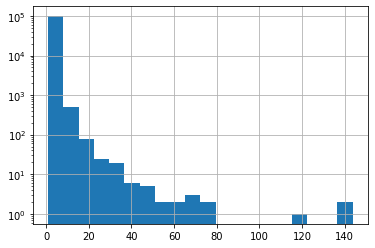

In [43]:
student_details['Average_rec_per_word'].hist(log=True,bins=20)

The distribution of the number of records per word for each student is skewed to the right. Most students had fewer than 10 records per word. 

The distribution of number of words learned per student is below:

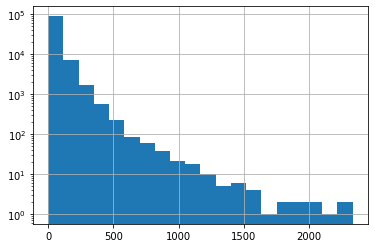

In [45]:
student_details['num_words'].hist(log=True,bins=20)

Most students practiced ~0- 100 words in the two week period. 

The distribution of number of records is below:

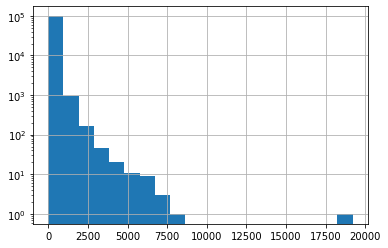

In [46]:
student_details['num_records'].hist(log=True,bins=20)

Most students have less than 1000 records, although there are around 10 students with > 17,500 records. Our test set should have a similar shaped distribution.

Now we will get the language group for each student.

In [54]:
lang_pairs = list(zip(datadf2_oneui['ui_language'],datadf2_oneui['learning_language']))
stud_lang_dict = dict(zip(list(datadf2_oneui['user_id']),lang_pairs))

In [56]:
len(stud_lang_dict.keys())

98693

In [59]:
student_details = student_details.reset_index()
student_details.head()

,user_id,num_words,num_records,Average_rec_per_word
0,u:-3I,13,14,1.076923
1,u:-3n,112,124,1.107143
2,u:-4V,13,26,2.000000
3,u:-4y,26,68,2.615385
4,u:-69,15,15,1.000000


In [60]:
student_details['lang_group'] = student_details['user_id'].map(stud_lang_dict)

In [61]:
student_details.head()

,user_id,num_words,num_records,Average_rec_per_word,lang_group
0,u:-3I,13,14,1.076923,"(en, fr)"
1,u:-3n,112,124,1.107143,"(en, es)"
2,u:-4V,13,26,2.000000,"(en, fr)"
3,u:-4y,26,68,2.615385,"(en, es)"
4,u:-69,15,15,1.000000,"(en, fr)"


We will go through each language group (ui , learning langugae), and get a random cut of 10% of the students, stratifying by average records per word. 

In [63]:
from sklearn.model_selection import train_test_split

In [64]:
lang_pair_counts

user_id  testset_counts
learning_language ui_language                         
en                es             31613          3161.3
                  pt              8591           859.1
es                en             31104          3110.4
fr                en             19878          1987.8
it                en              6463           646.3
pt                en              2679           267.9

We will filter by each language group and split students.

English to Spanish

,user_id,num_words,num_records,Average_rec_per_word,lang_group
0,u:-3I,13,14,1.076923,"(en, fr)"
1,u:-3n,112,124,1.107143,"(en, es)"
2,u:-4V,13,26,2.000000,"(en, fr)"
3,u:-4y,26,68,2.615385,"(en, es)"
4,u:-69,15,15,1.000000,"(en, fr)"


In [84]:
en_to_es = student_details.loc[student_details['lang_group']==('en','es')]
en_to_es_remaining, en_to_es_unseen_students, y_remaining, y_unseen_students = train_test_split(en_to_es[['user_id','num_words','num_records']],en_to_es['Average_rec_per_word'],test_size=0.1)

In [85]:
en_to_es_unseen_students['Average_rec_per_word'] = y_unseen_students

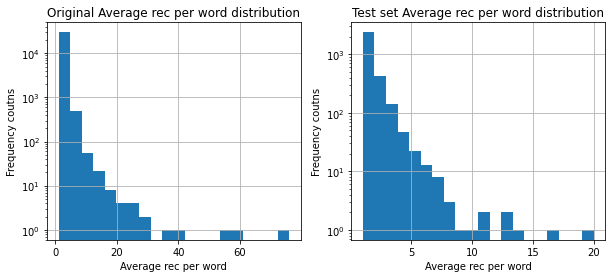

In [90]:
plt.subplots(1,2,figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Original Average rec per word distribution")
plt.xlabel("Average rec per word")
plt.ylabel("Frequency coutns")
en_to_es['Average_rec_per_word'].hist(log=True,bins=20)
plt.subplot(1,2,2)
plt.title("Test set Average rec per word distribution")
plt.xlabel("Average rec per word")
plt.ylabel("Frequency coutns")
en_to_es_unseen_students['Average_rec_per_word'].hist(log=True,bins=20)

In [101]:
en_to_es_unseen_students.shape

(3055, 4)

This will work. We will follow the same process for the other language groups, and then get the groups of user_id for training and testing, then split the datadf2 dataframe accordingly. 

en to pt

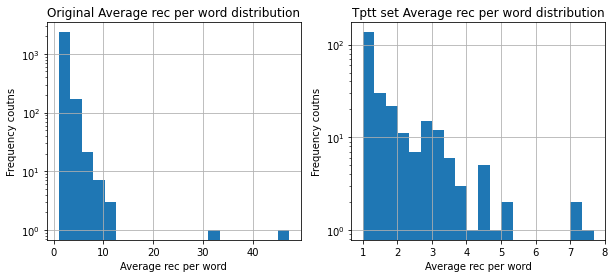

In [93]:
en_to_pt = student_details.loc[student_details['lang_group']==('en','pt')]
en_to_pt_remaining, en_to_pt_unseen_students, y_remaining, y_unseen_students = train_test_split(en_to_pt[['user_id','num_words','num_records']],en_to_pt['Average_rec_per_word'],test_size=0.1)
en_to_pt_unseen_students['Average_rec_per_word'] = y_unseen_students
plt.subplots(1,2,figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Original Average rec per word distribution")
plt.xlabel("Average rec per word")
plt.ylabel("Frequency coutns")
en_to_pt['Average_rec_per_word'].hist(log=True,bins=20)
plt.subplot(1,2,2)
plt.title("Tptt set Average rec per word distribution")
plt.xlabel("Average rec per word")
plt.ylabel("Frequency coutns")
en_to_pt_unseen_students['Average_rec_per_word'].hist(log=True,bins=20)

In [102]:
en_to_pt_unseen_students.shape

(254, 4)

es to en:

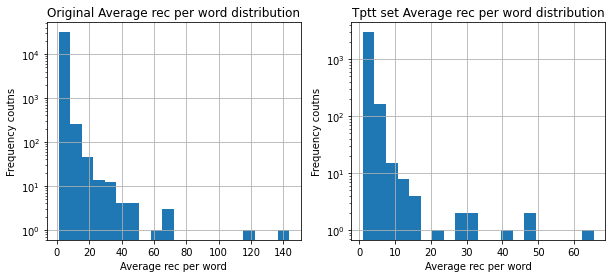

In [94]:
es_to_en = student_details.loc[student_details['lang_group']==('es','en')]
es_to_en_remaining, es_to_en_unseen_students, y_remaining, y_unseen_students = train_test_split(es_to_en[['user_id','num_words','num_records']],es_to_en['Average_rec_per_word'],test_size=0.1)
es_to_en_unseen_students['Average_rec_per_word'] = y_unseen_students
plt.subplots(1,2,figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Original Average rec per word distribution")
plt.xlabel("Average rec per word")
plt.ylabel("Frequency coutns")
es_to_en['Average_rec_per_word'].hist(log=True,bins=20)
plt.subplot(1,2,2)
plt.title("Test set Average rec per word distribution")
plt.xlabel("Average rec per word")
plt.ylabel("Frequency coutns")
es_to_en_unseen_students['Average_rec_per_word'].hist(log=True,bins=20)

English to French

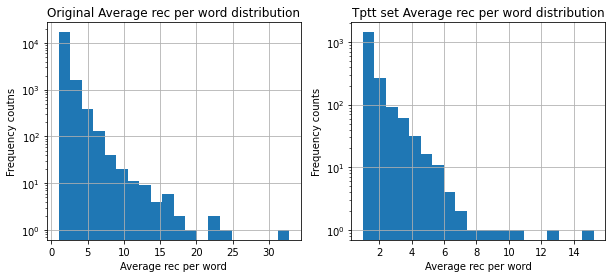

In [100]:
en_to_fr = student_details.loc[student_details['lang_group']==('en','fr')]
en_to_fr_remaining, en_to_fr_unseen_students, y_remaining, y_unseen_students = train_test_split(en_to_fr[['user_id','num_words','num_records']],en_to_fr['Average_rec_per_word'],test_size=0.1)
en_to_fr_unseen_students['Average_rec_per_word'] = y_unseen_students
plt.subplots(1,2,figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Original Average rec per word distribution")
plt.xlabel("Average rec per word")
plt.ylabel("Frequency coutns")
en_to_fr['Average_rec_per_word'].hist(log=True,bins=20)
plt.subplot(1,2,2)
plt.title("Tptt set Average rec per word distribution")
plt.xlabel("Average rec per word")
plt.ylabel("Frequency counts")
en_to_fr_unseen_students['Average_rec_per_word'].hist(log=True,bins=20)

In [103]:
en_to_fr_unseen_students.shape

(1924, 4)

English to italian

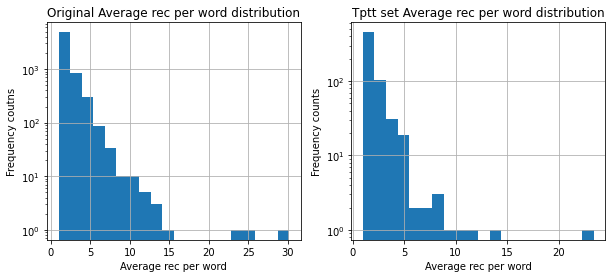

In [104]:
en_to_it = student_details.loc[student_details['lang_group']==('en','it')]
en_to_it_remaining, en_to_it_unseen_students, y_remaining, y_unseen_students = train_test_split(en_to_it[['user_id','num_words','num_records']],en_to_it['Average_rec_per_word'],test_size=0.1)
en_to_it_unseen_students['Average_rec_per_word'] = y_unseen_students
plt.subplots(1,2,figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Original Average rec per word distribution")
plt.xlabel("Average rec per word")
plt.ylabel("Frequency coutns")
en_to_it['Average_rec_per_word'].hist(log=True,bins=20)
plt.subplot(1,2,2)
plt.title("Tptt set Average rec per word distribution")
plt.xlabel("Average rec per word")
plt.ylabel("Frequency counts")
en_to_it_unseen_students['Average_rec_per_word'].hist(log=True,bins=20)

In [105]:
en_to_it_unseen_students.shape

(617, 4)

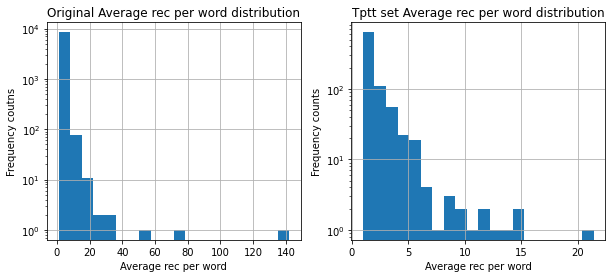

In [106]:
pt_to_en = student_details.loc[student_details['lang_group']==('pt','en')]
pt_to_en_remaining, pt_to_en_unseen_students, y_remaining, y_unseen_students = train_test_split(pt_to_en[['user_id','num_words','num_records']],pt_to_en['Average_rec_per_word'],test_size=0.1)
pt_to_en_unseen_students['Average_rec_per_word'] = y_unseen_students
plt.subplots(1,2,figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Original Average rec per word distribution")
plt.xlabel("Average rec per word")
plt.ylabel("Frequency coutns")
pt_to_en['Average_rec_per_word'].hist(log=True,bins=20)
plt.subplot(1,2,2)
plt.title("Tptt set Average rec per word distribution")
plt.xlabel("Average rec per word")
plt.ylabel("Frequency counts")
pt_to_en_unseen_students['Average_rec_per_word'].hist(log=True,bins=20)

In [107]:
pt_to_en_unseen_students.shape

(860, 4)

In [109]:
unseen_students = list(en_to_es_unseen_students['user_id']) + list(en_to_pt_unseen_students['user_id'])\
+list(es_to_en_unseen_students['user_id']) + list(en_to_fr_unseen_students['user_id'])\
+list(en_to_it_unseen_students['user_id']) + list(pt_to_en_unseen_students['user_id'])

In [110]:
unseen_students = set(unseen_students)

Now we have the test set user_id. 

In [112]:
unseen_students_test_set = datadf2.loc[datadf2['user_id'].isin(unseen_students),:]
unseen_students_test_set.shape

(1057521, 14)

In [115]:
unseen_students_test_set.shape[0]/datadf2.shape[0]*100

9.63362349322189

We have 10% of the dataset set apart for unseen students. We will save it as a compressed pickle file.

In [117]:
compressed_pickle(path_name+'Unseen_students_test_set',unseen_students_test_set)

In [118]:
datadf3 = datadf2.drop(unseen_students_test_set.index)

In [119]:
compressed_pickle(path_name+'Unseen_students_training_set',datadf3)